In [2]:
# create a list with the files that are not good and ignore them in the plotting and the fitting

In [ ]:
import os
import datascout as ds
import awkward as ak
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [3]:
# Plotting parameters
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 10,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [4]:
path2files = './example_WS_data_19Aug2021/'
files_list = sorted(os.listdir(path2files)[:-1])
print(files_list)

['2021.08.19.13.49.24.135000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.13.50.40.935000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.13.55.09.735000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.13.57.04.935000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.14.32.55.335000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.14.48.55.335000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.15.08.45.735000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.15.13.14.535000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.15.18.21.735000_SPS.BWS.41677.V-PM1.parquet']


## Part A:  Analysis for 1/80 bunches only for the Set 1 (IN acquisitions)

In [5]:
entry = 0
subentries = np.arange(0,80) # how many bunches
subsubentry=0 

In [8]:
data = ds.parquet_to_awkward(path2files+files_list[0]) # type: awkward.highlevel.Array
pd_data = ak.to_pandas(data) # convert awkward arrays to pandas for easier manipilation
pd_data.keys()

Index(['device', 'cycleStamp', 'cycleSelector', 'pmSelection', 'voltageSet',
       'intensity_Set1', 'emittance_Set1', 'emittance_average_Set1',
       'emittance_std_Set1', 'sigma_Set1', 'sigma_betatronic_Set1',
       'amplitude_Set1', 'area_Set1', 'acq_time_Set1', 'dpp_Set1', 'mask_Set1',
       'bunchSelection_Set1', 'betagamma_Set1', 'bestChannel_Set1',
       'beta_func_Set1', 'disp_func_Set1', 'profile_area_Set1',
       'analysis_span_Set1', 'fit_func_Set1', 'fit_values_Set1',
       'positions_Set1', 'profiles_Set1', 'intensity_Set2', 'emittance_Set2',
       'emittance_average_Set2', 'emittance_std_Set2', 'sigma_Set2',
       'sigma_betatronic_Set2', 'amplitude_Set2', 'area_Set2', 'acq_time_Set2',
       'dpp_Set2', 'mask_Set2', 'bunchSelection_Set2', 'betagamma_Set2',
       'bestChannel_Set2', 'beta_func_Set2', 'disp_func_Set2',
       'profile_area_Set2', 'analysis_span_Set2', 'fit_func_Set2',
       'fit_values_Set2', 'positions_Set2', 'profiles_Set2'],
      dtype='obje

In [5]:
# select bunch
bunch = subentries[0]

emit_list, days_list  = [], []

for filename in files_list:
    data = ds.parquet_to_awkward(path2files+filename) # type: awkward.highlevel.Array
    pd_data = ak.to_pandas(data) # convert awkward arrays to pandas for easier manipilation

    acq = pd_data['cycleStamp'][0][bunch][0]/1e9+ pd_data['acq_time_Set1'][0][bunch][0]/1e6 # sec
    t_corr = 2*3600
    days_list.append(md.epoch2num(acq+t_corr))  # Convert UNIX time to days since Matplotlib epoch.
    
    emit_list.append(pd_data['emittance_Set1'][0][bunch][0])

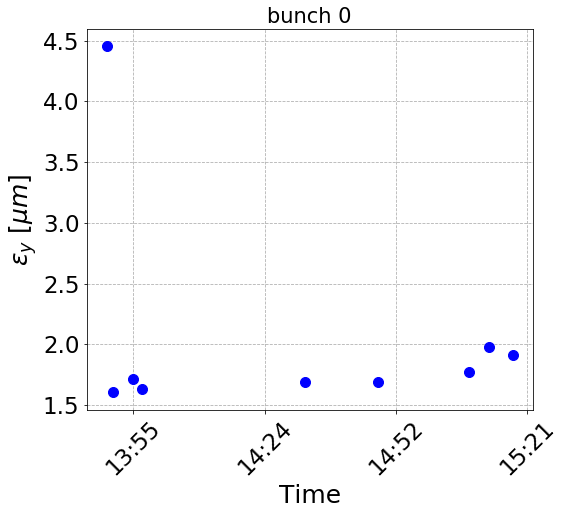

In [28]:
fig, ax = plt.subplots(1)

xfmt = md.DateFormatter('%H:%M')
    
ax.plot(days_list, np.array(emit_list)*1e6, 'o', c='b')
    
ax.set_title(f'bunch {bunch}')
ax.set_xlabel('Time')
ax.set_ylabel(r'$\epsilon_y \ [\mu m]$')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.gca().xaxis.set_major_formatter(xfmt)
plt.grid(ls='--')

In [16]:
# compute the emit grwoth in m/day
[m, b], cov = np.polyfit(days_list[1:], emit_list[1:], deg=1, cov=True)
err = np.sqrt(np.diag(cov))[0]
print ("Slope : " + str(m))
print ("Intercept : " + str(b))

Slope : 4.238123390396617e-06
Intercept : -3.1278248897648506


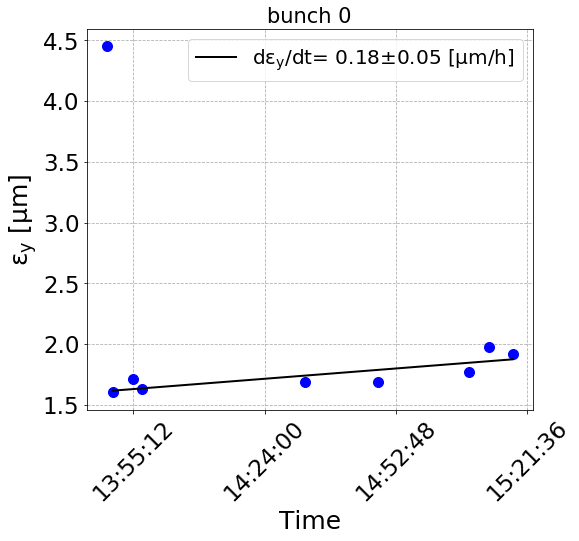

In [25]:
fig, ax = plt.subplots(1)

xfmt = md.DateFormatter('%H:%M:%S')
    
ax.plot(days_list, np.array(emit_list)*1e6, 'o', c='b')
    
ax.plot(days_list[1:], (np.array(days_list[1:])*m+b)*1e6, c='k', label=r'$\mathrm{d\epsilon_y/dt}$'+f'= {m*1e6/24:.2f}'+r'$\pm$'+f'{err*1e6/24:.2f} '+r'$\mathrm{[\mu m/h]}$')

ax.set_title(f'bunch {bunch}')
ax.set_xlabel('Time')
ax.set_ylabel(r'$\mathrm{\epsilon_y \ [\mu m]}$')
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=45)
plt.gca().xaxis.set_major_formatter(xfmt)
plt.grid(ls='--')